<a href="https://colab.research.google.com/github/mightymiklas/dibbitydabadoo/blob/main/BitcoinTradingStrategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [144]:
# Load libraries
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD


<a id='1.2'></a>
## 2.2. Loading the Data

In [145]:
btc_path = Path("bitstamp_flipped.csv")
btc_dataset = pd.read_csv(btc_path, index_col='date', 
                          infer_datetime_format = True, 
                          parse_dates= True)
                        

In [146]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [188]:
#calc daily returns 
btc_dataset["actual returns"] = btc_dataset["close"].pct_change()
btc_dataset.head()

,symbol,open,high,low,close,Volume BTC,Volume USD,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,RSI10,RSI30,RSI200,MA21,MA63,MA252,actual returns
date,,,,,,,,,,,,,,,,,,,,
2014-11-28,BTC/USD,363.59,381.34,360.57,376.28,3.221e+06,8617.15,376.280,376.280,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-29,BTC/USD,376.42,386.60,372.25,376.72,2.746e+06,7245.19,376.500,376.500,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001
2014-11-30,BTC/USD,376.57,381.99,373.32,373.34,1.146e+06,3046.33,375.447,375.447,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009
2014-12-01,BTC/USD,376.40,382.31,373.03,378.39,2.521e+06,6660.56,376.183,376.183,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014
2014-12-02,BTC/USD,378.39,382.86,375.23,379.25,2.594e+06,6832.53,376.796,376.796,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002


<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [189]:
# shape
btc_dataset.shape

(2672, 20)

In [190]:
# peek at data
set_option('display.width', 100)
btc_dataset.tail(5)

,symbol,open,high,low,close,Volume BTC,Volume USD,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,RSI10,RSI30,RSI200,MA21,MA63,MA252,actual returns
date,,,,,,,,,,,,,,,,,,,,
2022-03-18,BTC/USD,40963.22,42362.00,40068.88,41794.37,2125.123,8.882e+07,39961.558,39973.886,0.0,40239.939,40202.011,44837.414,58.136,50.926,49.870,39961.558,39785.915,48557.300,0.020
2022-03-19,BTC/USD,41781.96,42405.01,41553.88,42235.31,976.889,4.126e+07,39989.087,39971.518,1.0,40602.734,40333.192,44811.522,59.838,51.563,49.965,39989.087,39841.889,48532.696,0.011
2022-03-20,BTC/USD,42240.43,42324.06,40930.20,41242.14,1061.353,4.377e+07,40168.856,39964.167,1.0,40718.989,40391.833,44776.006,54.312,50.049,49.752,40168.856,39883.394,48494.640,-0.024
2022-03-21,BTC/USD,41293.19,41588.70,40516.86,41043.14,1779.498,7.304e+07,40400.191,39969.285,1.0,40777.926,40433.853,44738.863,53.218,49.746,49.709,40400.191,39914.531,48453.481,-0.005
2022-03-22,BTC/USD,41018.36,41867.13,40901.13,41732.03,210.062,8.766e+06,40691.192,40056.561,1.0,40951.399,40517.607,44708.944,56.582,50.812,49.859,40691.192,40026.469,48412.016,0.017


In [191]:
btc_dataset.head()

,symbol,open,high,low,close,Volume BTC,Volume USD,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,RSI10,RSI30,RSI200,MA21,MA63,MA252,actual returns
date,,,,,,,,,,,,,,,,,,,,
2014-11-28,BTC/USD,363.59,381.34,360.57,376.28,3.221e+06,8617.15,376.280,376.280,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-29,BTC/USD,376.42,386.60,372.25,376.72,2.746e+06,7245.19,376.500,376.500,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001
2014-11-30,BTC/USD,376.57,381.99,373.32,373.34,1.146e+06,3046.33,375.447,375.447,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009
2014-12-01,BTC/USD,376.40,382.31,373.03,378.39,2.521e+06,6660.56,376.183,376.183,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014
2014-12-02,BTC/USD,378.39,382.86,375.23,379.25,2.594e+06,6832.53,376.796,376.796,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002


In [192]:
# describe data
set_option('precision', 3)
btc_dataset.describe()

,open,high,low,close,Volume BTC,Volume USD,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,RSI10,RSI30,RSI200,MA21,MA63,MA252,actual returns
count,2672.000,2672.000,2672.000,2672.000,2.672e+03,2.672e+03,2672.000,2672.000,2672.000,2663.000,2643.000,2473.000,2662.000,2642.000,2472.000,2663.000,2643.000,2473.000,2671.000
mean,11918.914,12269.099,11516.848,11934.418,1.320e+07,6.113e+07,11865.420,11492.076,0.576,11904.913,11841.076,11085.047,53.997,53.539,53.411,11904.250,11841.699,11054.191,0.003
std,16406.581,16874.089,15851.549,16415.597,4.698e+07,1.069e+08,16346.194,15965.183,0.494,16344.446,16185.378,14320.850,16.019,10.444,4.903,16360.123,16246.641,14548.774,0.040
min,162.000,212.840,152.400,162.000,0.000e+00,0.000e+00,209.948,231.239,0.000,222.133,230.478,246.099,6.799,18.555,44.109,209.948,225.007,245.549,-0.390
25%,656.997,666.577,646.037,658.890,5.213e+03,9.595e+03,658.998,625.346,0.000,660.956,653.283,795.035,42.513,46.069,49.971,661.171,661.165,753.199,-0.013
50%,6444.120,6585.745,6338.175,6450.455,1.457e+04,2.398e+07,6464.863,6572.200,1.000,6488.594,6664.741,7394.326,52.984,52.735,52.499,6482.113,6576.531,7126.424,0.002
75%,10842.405,11177.003,10527.515,10850.455,3.361e+06,8.036e+07,10719.253,10592.608,1.000,10715.550,10718.811,9030.183,64.981,60.024,56.288,10734.360,10661.120,9519.211,0.019
max,67547.490,69000.000,66250.000,67559.000,7.723e+08,1.446e+09,64678.181,59846.740,1.000,64387.137,61828.138,50124.914,96.605,87.024,73.356,64678.181,62781.425,49455.326,0.289


<a id='3'></a>
# 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning

In [193]:
#Checking for any null values and removing the null values'''
print('Null Values =',btc_dataset.isnull().values.any())

Null Values = True


Given that there are null values, we need to clean the data by filling the *NaNs* with the last available values. 

<a id='3.2'></a>
## 4.2. Preparing the data for classification

We attach a label to each movement: 
* **1** if the signal is that short term price will go up as compared to the long term. 
* **0** if the signal is that short term price will go down as compared to the long term.

In [194]:
# Initialize the `signals` DataFrame with the `signal` column
#datas['PriceMove'] = 0.0

# Create short simple moving average over the short window
btc_dataset['short_mavg'] = btc_dataset['close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
btc_dataset['long_mavg'] = btc_dataset['close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
btc_dataset['signal'] = np.where(btc_dataset['short_mavg'] > btc_dataset['long_mavg'], 1.0, 0.0)

In [195]:
btc_dataset.tail()


,symbol,open,high,low,close,Volume BTC,Volume USD,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,RSI10,RSI30,RSI200,MA21,MA63,MA252,actual returns
date,,,,,,,,,,,,,,,,,,,,
2022-03-18,BTC/USD,40963.22,42362.00,40068.88,41794.37,2125.123,8.882e+07,39961.558,39973.886,0.0,40239.939,40202.011,44837.414,58.136,50.926,49.870,39961.558,39785.915,48557.300,0.020
2022-03-19,BTC/USD,41781.96,42405.01,41553.88,42235.31,976.889,4.126e+07,39989.087,39971.518,1.0,40602.734,40333.192,44811.522,59.838,51.563,49.965,39989.087,39841.889,48532.696,0.011
2022-03-20,BTC/USD,42240.43,42324.06,40930.20,41242.14,1061.353,4.377e+07,40168.856,39964.167,1.0,40718.989,40391.833,44776.006,54.312,50.049,49.752,40168.856,39883.394,48494.640,-0.024
2022-03-21,BTC/USD,41293.19,41588.70,40516.86,41043.14,1779.498,7.304e+07,40400.191,39969.285,1.0,40777.926,40433.853,44738.863,53.218,49.746,49.709,40400.191,39914.531,48453.481,-0.005
2022-03-22,BTC/USD,41018.36,41867.13,40901.13,41732.03,210.062,8.766e+06,40691.192,40056.561,1.0,40951.399,40517.607,44708.944,56.582,50.812,49.859,40691.192,40026.469,48412.016,0.017


<a id='3.3'></a>
## 4.3. Feature Engineering

We begin by the constructing a dataset that contains the predictors which will be used to make the predictions, and the output variable.

The current Data of the bicoin consists of date, open, high, low, close and Volume. Using this data we calculate the following  technical indicators:
* **Moving Average** : A moving average provides an indication of the trend of the price movement by cut down the amount of "noise" on a price chart. 

* **Relative Strength Index(RSI)** :It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. 


In [196]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(btc_dataset["close"].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
btc_dataset['EMA10'] = EMA(btc_dataset, 10)
btc_dataset['EMA30'] = EMA(btc_dataset, 30)
btc_dataset['EMA200'] = EMA(btc_dataset, 200)
btc_dataset.head()



#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)

btc_dataset['RSI10'] = RSI(btc_dataset['close'], 10)
btc_dataset['RSI30'] = RSI(btc_dataset['close'], 30)
btc_dataset['RSI200'] = RSI(btc_dataset['close'], 200)

btc_dataset.tail()

,symbol,open,high,low,close,Volume BTC,Volume USD,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,RSI10,RSI30,RSI200,MA21,MA63,MA252,actual returns
date,,,,,,,,,,,,,,,,,,,,
2022-03-18,BTC/USD,40963.22,42362.00,40068.88,41794.37,2125.123,8.882e+07,39961.558,39973.886,0.0,40239.939,40202.011,44837.414,58.136,50.926,49.870,39961.558,39785.915,48557.300,0.020
2022-03-19,BTC/USD,41781.96,42405.01,41553.88,42235.31,976.889,4.126e+07,39989.087,39971.518,1.0,40602.734,40333.192,44811.522,59.838,51.563,49.965,39989.087,39841.889,48532.696,0.011
2022-03-20,BTC/USD,42240.43,42324.06,40930.20,41242.14,1061.353,4.377e+07,40168.856,39964.167,1.0,40718.989,40391.833,44776.006,54.312,50.049,49.752,40168.856,39883.394,48494.640,-0.024
2022-03-21,BTC/USD,41293.19,41588.70,40516.86,41043.14,1779.498,7.304e+07,40400.191,39969.285,1.0,40777.926,40433.853,44738.863,53.218,49.746,49.709,40400.191,39914.531,48453.481,-0.005
2022-03-22,BTC/USD,41018.36,41867.13,40901.13,41732.03,210.062,8.766e+06,40691.192,40056.561,1.0,40951.399,40517.607,44708.944,56.582,50.812,49.859,40691.192,40026.469,48412.016,0.017


In [197]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(btc_dataset['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
btc_dataset['MA21'] = MA(btc_dataset, 10)
btc_dataset['MA63'] = MA(btc_dataset, 30)
btc_dataset['MA252'] = MA(btc_dataset, 200)
btc_dataset.tail()

,symbol,open,high,low,close,Volume BTC,Volume USD,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,RSI10,RSI30,RSI200,MA21,MA63,MA252,actual returns
date,,,,,,,,,,,,,,,,,,,,
2022-03-18,BTC/USD,40963.22,42362.00,40068.88,41794.37,2125.123,8.882e+07,39961.558,39973.886,0.0,40239.939,40202.011,44837.414,58.136,50.926,49.870,39961.558,39785.915,48557.300,0.020
2022-03-19,BTC/USD,41781.96,42405.01,41553.88,42235.31,976.889,4.126e+07,39989.087,39971.518,1.0,40602.734,40333.192,44811.522,59.838,51.563,49.965,39989.087,39841.889,48532.696,0.011
2022-03-20,BTC/USD,42240.43,42324.06,40930.20,41242.14,1061.353,4.377e+07,40168.856,39964.167,1.0,40718.989,40391.833,44776.006,54.312,50.049,49.752,40168.856,39883.394,48494.640,-0.024
2022-03-21,BTC/USD,41293.19,41588.70,40516.86,41043.14,1779.498,7.304e+07,40400.191,39969.285,1.0,40777.926,40433.853,44738.863,53.218,49.746,49.709,40400.191,39914.531,48453.481,-0.005
2022-03-22,BTC/USD,41018.36,41867.13,40901.13,41732.03,210.062,8.766e+06,40691.192,40056.561,1.0,40951.399,40517.607,44708.944,56.582,50.812,49.859,40691.192,40026.469,48412.016,0.017


In [198]:
btc_dataset.tail(10)

,symbol,open,high,low,close,Volume BTC,Volume USD,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,RSI10,RSI30,RSI200,MA21,MA63,MA252,actual returns
date,,,,,,,,,,,,,,,,,,,,
2022-03-13,BTC/USD,38798.68,39312.50,37595.62,37790.54,737.880,2.788e+07,39054.818,40161.725,0.0,39258.113,40023.642,45055.411,41.795,44.924,49.002,39054.818,40201.727,48746.478,-0.027
2022-03-14,BTC/USD,37763.37,39913.42,37567.19,39665.71,1439.768,5.711e+07,39103.833,40113.287,0.0,39332.221,40000.549,45001.782,49.920,47.776,49.409,39103.833,40115.880,48710.525,0.050
2022-03-15,BTC/USD,39688.55,39896.13,38142.35,39302.70,1638.684,6.440e+07,39092.424,40049.960,0.0,39326.854,39955.527,44945.075,48.465,47.286,49.333,39092.424,40023.379,48661.536,-0.009
2022-03-16,BTC/USD,39302.80,41693.97,38865.67,41142.76,5987.104,2.463e+08,39362.811,40017.306,0.0,39657.019,40032.122,44907.241,55.733,49.977,49.730,39362.811,39976.794,48622.573,0.047
2022-03-17,BTC/USD,41142.76,41497.24,40449.06,40963.22,1657.762,6.791e+07,39657.486,39981.564,0.0,39894.510,40092.193,44867.997,54.893,49.721,49.691,39657.486,39856.152,48583.346,-0.004
2022-03-18,BTC/USD,40963.22,42362.00,40068.88,41794.37,2125.123,8.882e+07,39961.558,39973.886,0.0,40239.939,40202.011,44837.414,58.136,50.926,49.870,39961.558,39785.915,48557.300,0.020
2022-03-19,BTC/USD,41781.96,42405.01,41553.88,42235.31,976.889,4.126e+07,39989.087,39971.518,1.0,40602.734,40333.192,44811.522,59.838,51.563,49.965,39989.087,39841.889,48532.696,0.011
2022-03-20,BTC/USD,42240.43,42324.06,40930.20,41242.14,1061.353,4.377e+07,40168.856,39964.167,1.0,40718.989,40391.833,44776.006,54.312,50.049,49.752,40168.856,39883.394,48494.640,-0.024
2022-03-21,BTC/USD,41293.19,41588.70,40516.86,41043.14,1779.498,7.304e+07,40400.191,39969.285,1.0,40777.926,40433.853,44738.863,53.218,49.746,49.709,40400.191,39914.531,48453.481,-0.005


In [199]:
#excluding columns that are not needed for our prediction.

btc_dataset_dr = btc_dataset.drop(['symbol','high','low','open', 'short_mavg','long_mavg'], axis=1)

In [200]:
btc_dataset_dr = btc_dataset_dr.dropna(axis=0)

In [201]:
btc_dataset_dr.tail()

,close,Volume BTC,Volume USD,signal,EMA10,EMA30,EMA200,RSI10,RSI30,RSI200,MA21,MA63,MA252,actual returns
date,,,,,,,,,,,,,,
2022-03-18,41794.37,2125.123,8.882e+07,0.0,40239.939,40202.011,44837.414,58.136,50.926,49.870,39961.558,39785.915,48557.300,0.020
2022-03-19,42235.31,976.889,4.126e+07,1.0,40602.734,40333.192,44811.522,59.838,51.563,49.965,39989.087,39841.889,48532.696,0.011
2022-03-20,41242.14,1061.353,4.377e+07,1.0,40718.989,40391.833,44776.006,54.312,50.049,49.752,40168.856,39883.394,48494.640,-0.024
2022-03-21,41043.14,1779.498,7.304e+07,1.0,40777.926,40433.853,44738.863,53.218,49.746,49.709,40400.191,39914.531,48453.481,-0.005
2022-03-22,41732.03,210.062,8.766e+06,1.0,40951.399,40517.607,44708.944,56.582,50.812,49.859,40691.192,40026.469,48412.016,0.017


<a id='3.4'></a>
## 4.4. Data Visualization

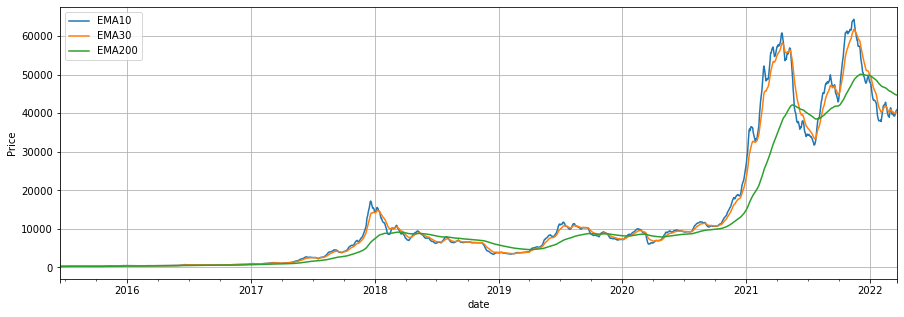

In [202]:
#Reminder to put something meaningful here!

btc_dataset_dr[['EMA10','EMA30', 'EMA200']].plot(grid=True, figsize=(15,5), ylabel='Price')
plt.show()

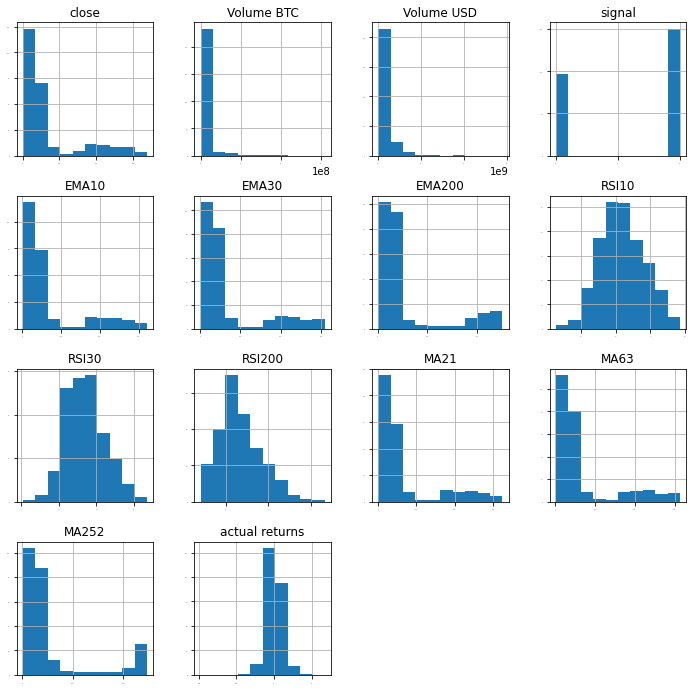

In [203]:
# histograms
btc_dataset_dr.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

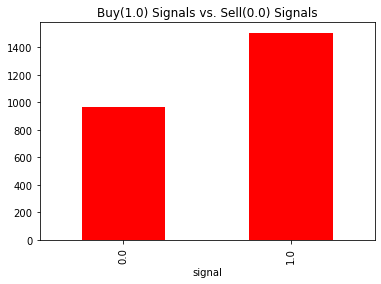

In [204]:
btc_dataset_dr.groupby(['signal']).size().plot(kind='bar', color='red', title = ("Buy(1.0) Signals vs. Sell(0.0) Signals"))
plt.show()

In [205]:
y.value_counts()

1.0    1505
0.0     967
Name: signal, dtype: int64

According to this chart, the number of buy signals outnumbered sell signals 61% to 39%

<AxesSubplot:title={'center':'Correlation Matrix'}>

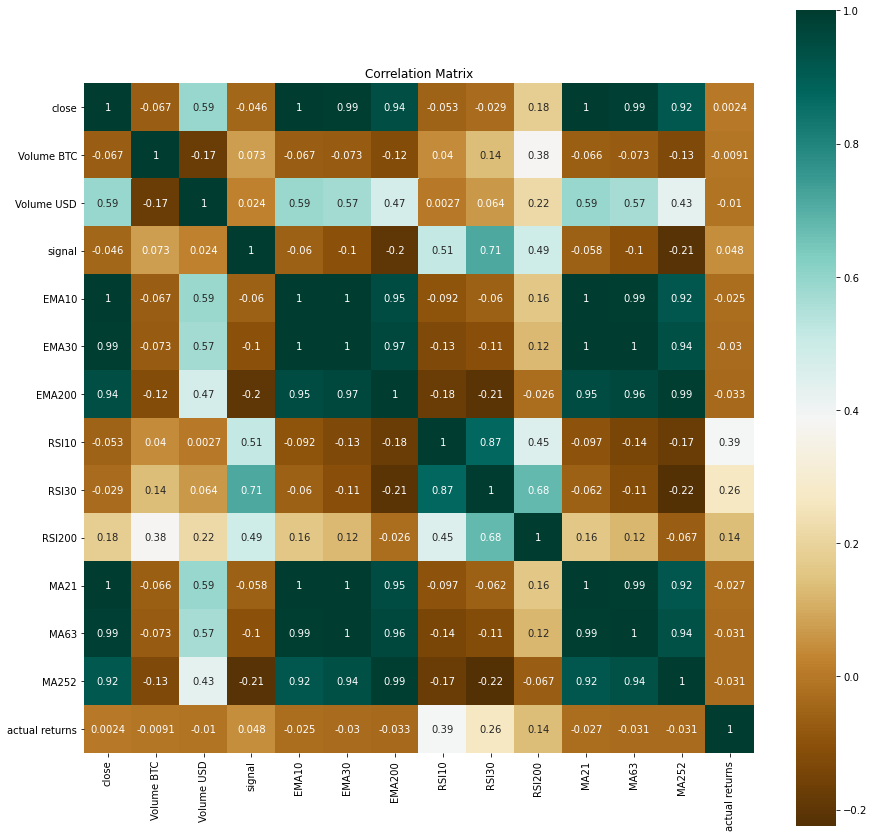

In [206]:
# correlation
correlation = btc_dataset_dr.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='BrBG')

In [207]:
X = btc_dataset_dr[['EMA10','EMA30', 'EMA200']].shift().dropna()

# Display sample data
display(X.head())
display(X.tail())


,EMA10,EMA30,EMA200
date,,,
2015-06-17,233.739,232.113,246.337
2015-06-18,235.929,232.995,246.331
2015-06-19,238.140,233.969,246.351
2015-06-20,239.100,234.578,246.318
2015-06-21,240.116,235.231,246.299


,EMA10,EMA30,EMA200
date,,,
2022-03-18,39894.510,40092.193,44867.997
2022-03-19,40239.939,40202.011,44837.414
2022-03-20,40602.734,40333.192,44811.522
2022-03-21,40718.989,40391.833,44776.006
2022-03-22,40777.926,40433.853,44738.863


In [208]:
y = btc_dataset_dr['signal']

In [230]:
from pandas.tseries.offsets import DateOffset
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

training_end = X.index.min() + DateOffset(years=5)
training_end_delta = training_end + DateOffset(days=1)

print(training_end_delta)

2015-06-17 00:00:00
2020-06-18 00:00:00


In [231]:
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

X_train.tail()

,EMA10,EMA30,EMA200
date,,,
2020-06-13,9604.859,9396.668,8423.973
2020-06-14,9580.968,9401.623,8434.415
2020-06-15,9535.336,9397.001,8443.327
2020-06-16,9517.120,9399.462,8453.195
2020-06-17,9519.517,9407.903,8463.913


In [232]:
X_test = X.loc[training_end_delta:]
y_test = y.loc[training_end_delta:]

X_test.head()

,EMA10,EMA30,EMA200
date,,,
2020-06-18,9508.930,9411.348,8473.837
2020-06-19,9484.539,9408.989,8482.802
2020-06-20,9451.772,9402.236,8490.976
2020-06-21,9434.261,9399.218,8499.578
2020-06-22,9406.764,9391.722,8507.373


In [233]:
#module
from sklearn.preprocessing import StandardScaler


# Create a StandardScaler instance
scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

X_train.tail()

,EMA10,EMA30,EMA200
date,,,
2020-06-13,9604.859,9396.668,8423.973
2020-06-14,9580.968,9401.623,8434.415
2020-06-15,9535.336,9397.001,8443.327
2020-06-16,9517.120,9399.462,8453.195
2020-06-17,9519.517,9407.903,8463.913


In [234]:
from sklearn.metrics import classification_report
from sklearn import svm

#Train SVM
svm_model = svm.SVC()

svm_model1 = svm_model.fit(X_train_scaled, y_train)

training_signal_predictions = svm_model.predict(X_train_scaled)

training_signal_predictions[:10]

training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

         0.0       0.90      0.74      0.81       692
         1.0       0.86      0.95      0.90      1136

    accuracy                           0.87      1828
   macro avg       0.88      0.84      0.86      1828
weighted avg       0.87      0.87      0.87      1828



In [235]:
#Test SVM 

testing_signal_predictions = svm_model.predict(X_test_scaled)

testing_report = classification_report(y_test, testing_signal_predictions)

print(testing_report)

              precision    recall  f1-score   support

         0.0       0.43      0.18      0.25       274
         1.0       0.58      0.83      0.68       369

    accuracy                           0.55       643
   macro avg       0.50      0.50      0.47       643
weighted avg       0.52      0.55      0.50       643



In [236]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [237]:
#Train LR Model

model_lr = lr.fit(X_train_scaled, y_train)

train_signal_predictions_lr = model_lr.predict(X_train_scaled)

training_report_lr = classification_report(y_train, train_signal_predictions_lr)

print(training_report_lr)

              precision    recall  f1-score   support

         0.0       0.84      0.70      0.76       692
         1.0       0.83      0.92      0.88      1136

    accuracy                           0.84      1828
   macro avg       0.84      0.81      0.82      1828
weighted avg       0.84      0.84      0.83      1828



In [238]:
#Test LR Model

test_signal_predictions_lr = model_lr.predict(X_test_scaled)

test_report_lr = classification_report(y_test, test_signal_predictions_lr)
print(test_report_lr)

              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88       274
         1.0       1.00      0.79      0.88       369

    accuracy                           0.88       643
   macro avg       0.89      0.90      0.88       643
weighted avg       0.91      0.88      0.88       643



In [239]:
# Import Modules
from sklearn.metrics import confusion_matrix,classification_report

# Print confusion matrix
print(confusion_matrix(y_test, test_signal_predictions_lr))

[[274   0]
 [ 77 292]]


In [245]:
# Create a predictions DataFrame for SVM
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted signal"] = testing_signal_predictions

predictions_df["actual returns"] = btc_dataset_dr["actual returns"]

predictions_df["trading algorithm returns"] = (
    predictions_df["actual returns"] * predictions_df["predicted signal"]
)

# Review the DataFrame
predictions_df.tail()

,predicted signal,actual returns,trading algorithm returns
date,,,
2022-03-18,1.0,0.020,0.020
2022-03-19,1.0,0.011,0.011
2022-03-20,1.0,-0.024,-0.024
2022-03-21,1.0,-0.005,-0.005
2022-03-22,1.0,0.017,0.017


<AxesSubplot:title={'center':'Actual vs Algo Returns for Support Vector ML'}, xlabel='date'>

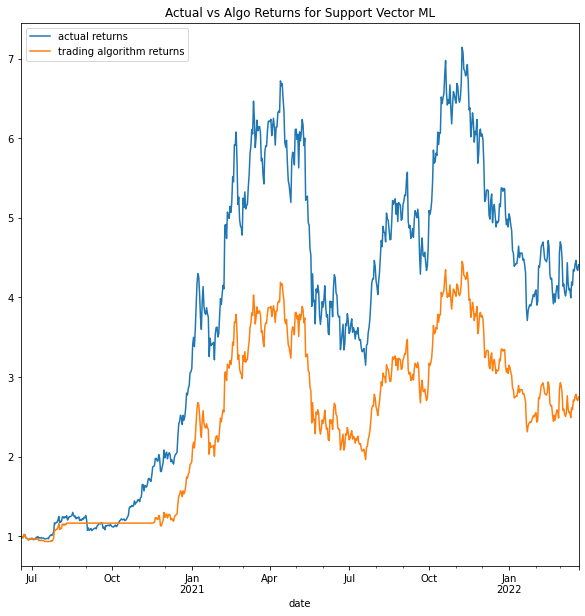

In [254]:
(1 + predictions_df[["actual returns", "trading algorithm returns"]]).cumprod().plot(figsize=(10,10), title= "Actual vs Algo Returns for Support Vector ML")

In [247]:
# Create a predictions DataFrame for LM
predictions_df_lr = pd.DataFrame(index=X_test.index)

predictions_df_lr["predicted signal"] = test_signal_predictions_lr

predictions_df_lr["actual returns"] = btc_dataset_dr["actual returns"]

predictions_df_lr["trading algorithm returns"] = (
    predictions_df_lr["actual returns"] * predictions_df_lr["predicted signal"]
)

# Review the DataFrame
predictions_df.head()

,predicted signal,actual returns,trading algorithm returns
date,,,
2020-06-18,1.0,-0.009,-0.009
2020-06-19,1.0,-0.008,-0.008
2020-06-20,1.0,0.005,0.005
2020-06-21,1.0,-0.008,-0.008
2020-06-22,1.0,0.043,0.043


<AxesSubplot:title={'center':'Actual vs Algo Returns for Logistic Regression Model'}, xlabel='date'>

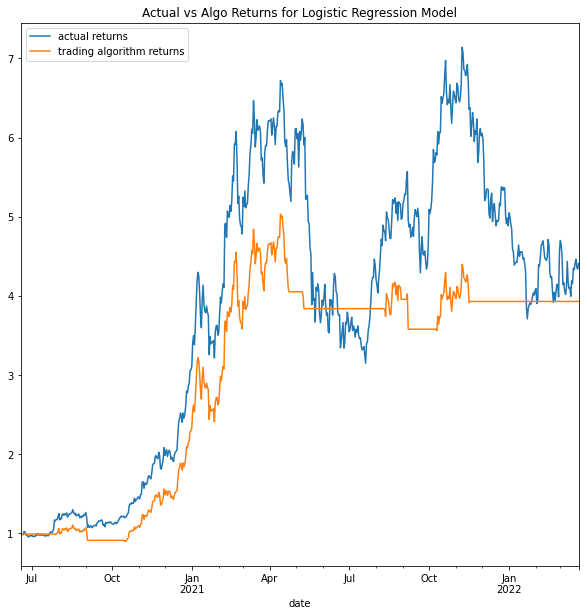

In [253]:
(1 + predictions_df_lr[["actual returns", "trading algorithm returns"]]).cumprod().plot(figsize=(10,10), title= "Actual vs Algo Returns for Logistic Regression ML")